# XFeat matching example (sparse and semi-dense)

## First, clone repository

In [6]:
# !cd /content && git clone 'https://github.com/verlab/accelerated_features.git'
# %cd /content/accelerated_features

import sys
import os

# 获取当前 notebook 文件的路径
notebook_path = os.path.abspath('')

# 获取模块文件夹的路径
modules_path = os.path.join(notebook_path, '..')

# 添加模块文件夹到 Python 路径中
if modules_path not in sys.path:
    sys.path.append(modules_path)

## Initialize XFeat

In [7]:
import numpy as np
import os
import torch
import tqdm
import cv2
import matplotlib.pyplot as plt

from modules.xfeat import XFeat

xfeat = XFeat(device='cuda:1')

#Load some example images
im1 = cv2.imread('../assets/ref.png')
im2 = cv2.imread('../assets/tgt.png')

loading weights from: /home/lmy/mycode/accelerated_features/modules/../weights/xfeat.pt


/home/lmy/mycode/accelerated_features/notebooks/../modules/xfeat.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(weights, map_locati

## Simple function that fits an homography in a set of matches and draw the homography transform

In [8]:
import cv2
import numpy as np

def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(p[0], p[1], 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(p[0], p[1], 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches


## Matching example - sparse setting

Loaded LightGlue model


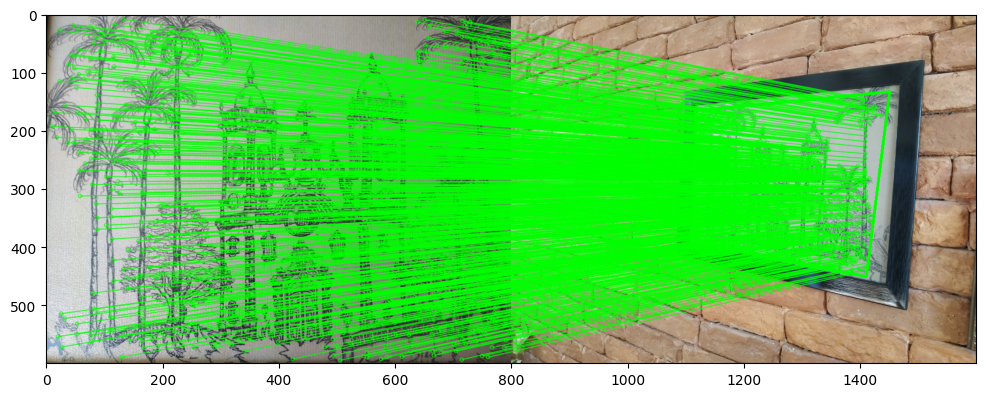

(<matplotlib.image.AxesImage at 0x7277043acda0>, None)

In [9]:
# Inference with batch = 1
output0 = xfeat.detectAndCompute(im1, top_k = 4096)[0]
output1 = xfeat.detectAndCompute(im2, top_k = 4096)[0]

#Update with image resolution (required)
output0.update({'image_size': (im1.shape[1], im1.shape[0])})
output1.update({'image_size': (im2.shape[1], im2.shape[0])})

mkpts_0, mkpts_1, _ = xfeat.match_lighterglue(output0, output1)

canvas = warp_corners_and_draw_matches(mkpts_0, mkpts_1, im1, im2)
plt.figure(figsize=(12,12))
plt.imshow(canvas[..., ::-1]), plt.show()

In [10]:
import time

# Run the model 100 times to get an average time
loop = 100
start = time.perf_counter()
for i in tqdm.tqdm(range(loop)):
  outputs = xfeat.match_lighterglue_full(im1, im2, top_k = 4096)
duration = time.perf_counter()-start

print(f"Average time per batch: {duration/loop:.4f} seconds")
print(f"Average time per image: {duration/loop:.4f} seconds")
print(f"Average FPS per image: {loop/duration:.4f}")

100%|██████████| 100/100 [00:01<00:00, 56.57it/s]

Average time per batch: 0.0177 seconds
Average time per image: 0.0177 seconds
Average FPS per image: 56.4557
